# Feature Importance

In [32]:
import json
import pandas as pd
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent.parent))
from models.encoder.common import METRICS_DIR

FEATURE_NAME_MAPPING = {
    "extract_word_length_by_char": "Word Length",
    "extract_ngram_word_length_by_char": "Word Length Trigram",
    "extract_sentence_length_by_word": "Sentence Length",
    "extract_char_ngrams": "Character N-Gram Frequency",
    "extract_punctuation": "Punctuation Frequency",
    "extract_pos_frequency": "Morph. POS Frequency",
    "extract_pos_ngrams": "Morph. POS N-Gram Frequency",
    "extract_dependency_tree_structure": "Dep. Tree Structure",
    "extract_dependency_tree_relations": "Dep. Tree N-Gram Frequency",
    "extract_casing": "Casing-Position Frequency",
    "extract_casing_bigrams": "Casing Bigram Frequency",
    "extract_ttr": "Type-Token Ratio (TTR)",
    "extract_lexical_density": "Lexical Density",
    "extract_sentence_length_by_word_avg": "Sentence Length Average",
    "extract_syllable_count_avg": "Syllable Count Average",
    "extract_3+syllable_count_ratio": "3+ Syllable Word Ratio",
    "extract_stopwords": "Stopword Ratio",
    "extract_noun_phrase_lengths": "Noun Phrase Frequency",
    "extract_supersense": "Supersense Frequency",
    "extract_entity_categories": "Named Entity Frequency",
    "extract_events": "Event Ratio",
    "extract_places": "Place Ratio",
    "extract_tense": "Tense Ratio",
    "extract_numeric_word_ratio": "Numeric Word Ratio",
    "extract_quote_ratio": "Quote Ratio",
    "extract_contractions": "Contraction Ratio",
    "extract_articles": "Article Ratio",
    "extract_word_concreteness": "Word Concreteness Frequency",
    "extract_word_concreteness_avg": "Word Concreteness Average",
    "extract_preposition_imageability": "Preposition Imageability Frequency",
    "extract_preposition_imageability_avg": "Preposition Imageability Average",
    "extract_polysemy": "Polysemy Frequency",
}


def load_metrics(pattern):
    """Load and average metrics from JSON files matching the pattern."""
    files = list((METRICS_DIR / "feature-importance").glob(pattern))
    if not files:
        return None
    all_metrics = []
    for filepath in files:
        with open(filepath, "r") as f:
            metrics = json.load(f)
            all_metrics.append(metrics)
    if not all_metrics:
        return None
    # Average the metrics
    averaged = {}
    keys = ["mse", "accuracy", "f1"]
    for key in keys:
        if key == "f1":
            # Average element-wise
            f1_lists = [m.get("f1", []) for m in all_metrics]
            if f1_lists and all(len(lst) == len(f1_lists[0]) for lst in f1_lists):
                averaged["f1"] = [sum(x) / len(f1_lists) for x in zip(*f1_lists)]
            else:
                averaged["f1"] = []
        else:
            values = [m.get(key, 0) for m in all_metrics]
            averaged[key] = sum(values) / len(values) if values else 0
    return {"averaged": averaged, "all": all_metrics}


# Load baseline (all features)
baseline_metrics = load_metrics("catboost_minilm_catboost-minilm-s*_test_*.json")
if baseline_metrics:
    baseline_averaged = baseline_metrics["averaged"]
    baseline_all = baseline_metrics["all"]
else:
    baseline_averaged = None
    baseline_all = None

# Load features only (no embeddings)
features_only_metrics = load_metrics("catboost_minilm_features-minilm-s*_test_*.json")
if features_only_metrics:
    features_only_averaged = features_only_metrics["averaged"]
    features_only_all = features_only_metrics["all"]
else:
    features_only_averaged = None
    features_only_all = None

# Load metrics for each removed feature group
removed_group_averaged = {}
removed_group_all = {}
for group in FEATURE_NAME_MAPPING.keys():
    metrics = load_metrics(f"catboost_minilm_features-{group}-s*_test_*.json")
    if metrics:
        removed_group_averaged[group] = metrics["averaged"]
        removed_group_all[group] = metrics["all"]
    else:
        removed_group_averaged[group] = None
        removed_group_all[group] = None

print(f"Loaded baseline metrics: {baseline_averaged is not None}")
print(f"Loaded features-only metrics: {features_only_averaged is not None}")
print(
    f"Loaded {sum(1 for m in removed_group_averaged.values() if m is not None)}/{len(FEATURE_NAME_MAPPING)} removed group metrics"
)

# Debug: print averaged values
if baseline_averaged:
    print(
        f"Baseline averaged MSE: {baseline_averaged['mse']:.4f}, Accuracy: {baseline_averaged['accuracy']:.4f}"
    )
if features_only_averaged:
    print(
        f"Features-only averaged MSE: {features_only_averaged['mse']:.4f}, Accuracy: {features_only_averaged['accuracy']:.4f}"
    )

Loaded baseline metrics: True
Loaded features-only metrics: True
Loaded 32/32 removed group metrics
Baseline averaged MSE: 0.7396, Accuracy: 0.5013
Features-only averaged MSE: 0.7432, Accuracy: 0.4885


In [33]:
import math
import numpy as np

rows = []


def macro_f1(m):
    return sum(m["f1"]) / len(m["f1"]) if m else None


def delta_stats(all_metrics, baseline_metrics, value_fn):
    if not baseline_metrics or not all_metrics:
        return float("nan"), float("nan")
    deltas = [value_fn(g) - value_fn(b) for g, b in zip(all_metrics, baseline_metrics)]
    if not deltas:
        return float("nan"), float("nan")
    mean_delta = float(np.mean(deltas))
    std_delta = float(np.std(deltas, ddof=1)) if len(deltas) > 1 else 0.0
    return mean_delta, 2 * std_delta


baseline_macro_f1 = None
if baseline_averaged:
    baseline_rmse = math.sqrt(baseline_averaged["mse"])
    baseline_macro_f1 = macro_f1(baseline_averaged)
    rows.append(
        {
            "Removed Feature Group": "None – Baseline",
            "RMSE": baseline_rmse,
            "Accuracy": baseline_averaged["accuracy"],
            "Macro Avg F1": baseline_macro_f1,
            "RMSE Δ": 0.0,
            "RMSE 2σ": 0.0,
            "Accuracy Δ": 0.0,
            "Accuracy 2σ": 0.0,
            "Macro F1 Δ": 0.0,
            "Macro F1 2σ": 0.0,
        }
    )

if features_only_averaged:
    features_only_rmse = math.sqrt(features_only_averaged["mse"])
    rmse_delta_mean, rmse_delta_2sigma = delta_stats(
        features_only_all, baseline_all, lambda m: math.sqrt(m["mse"])
    )
    acc_delta_mean, acc_delta_2sigma = delta_stats(
        features_only_all, baseline_all, lambda m: m["accuracy"]
    )
    macro_delta_mean, macro_delta_2sigma = delta_stats(
        features_only_all, baseline_all, macro_f1
    )
    rows.append(
        {
            "Removed Feature Group": "MiniLM embeddings",
            "RMSE": features_only_rmse,
            "Accuracy": features_only_averaged["accuracy"],
            "Macro Avg F1": macro_f1(features_only_averaged),
            "RMSE Δ": rmse_delta_mean,
            "RMSE 2σ": rmse_delta_2sigma,
            "Accuracy Δ": acc_delta_mean,
            "Accuracy 2σ": acc_delta_2sigma,
            "Macro F1 Δ": macro_delta_mean,
            "Macro F1 2σ": macro_delta_2sigma,
        }
    )

for group in FEATURE_NAME_MAPPING.keys():
    metrics = removed_group_averaged[group]
    all_metrics = removed_group_all[group]
    if metrics:
        human_name = FEATURE_NAME_MAPPING.get(
            group, group.replace("extract_", "").replace("_", " ").title()
        )
        rmse_delta_mean, rmse_delta_2sigma = delta_stats(
            all_metrics, baseline_all, lambda m: math.sqrt(m["mse"])
        )
        acc_delta_mean, acc_delta_2sigma = delta_stats(
            all_metrics, baseline_all, lambda m: m["accuracy"]
        )
        macro_delta_mean, macro_delta_2sigma = delta_stats(
            all_metrics, baseline_all, macro_f1
        )
        rows.append(
            {
                "Removed Feature Group": human_name,
                "RMSE": math.sqrt(metrics["mse"]),
                "Accuracy": metrics["accuracy"],
                "Macro Avg F1": macro_f1(metrics),
                "RMSE Δ": rmse_delta_mean,
                "RMSE 2σ": rmse_delta_2sigma,
                "Accuracy Δ": acc_delta_mean,
                "Accuracy 2σ": acc_delta_2sigma,
                "Macro F1 Δ": macro_delta_mean,
                "Macro F1 2σ": macro_delta_2sigma,
            }
        )

df = pd.DataFrame(rows)

# Configuration options
columns_to_include = [
    "Removed Feature Group",
    "RMSE",
    "RMSE Δ",
    "Accuracy Δ",
]
sort_column = "RMSE Δ"
sort_ascending = False
# gradient_columns: list of columns to apply gradient. Prefix with "-" to reverse direction (higher = better)
gradient_columns = ["-RMSE Δ", "Accuracy Δ"]

# Apply selections
df = df[columns_to_include]
df = df.sort_values(sort_column, ascending=sort_ascending).reset_index(drop=True)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")


def highlight_baselines(row):
    config = row["Removed Feature Group"]
    if "Baseline" in config:
        return ["font-weight: bold;"] * len(row)
    return [""] * len(row)


# Dynamic format dict for numeric columns
format_dict = {
    col: "{:.4f}" for col in df.columns if col not in ["Removed Feature Group"]
}

styled_df = df.style.format(format_dict).apply(highlight_baselines, axis=1)

# Apply gradients to specified columns
for grad_col in gradient_columns:
    if grad_col.startswith("-"):
        actual_col = grad_col[1:]
        cmap = "RdYlGn"  # Green to red: higher values better
    else:
        actual_col = grad_col
        cmap = "RdYlGn_r"  # Red to green: higher values worse
    if actual_col in df.columns:
        # Center the gradient at 0 (yellow) by using symmetric min/max
        abs_max = max(abs(df[actual_col].min()), abs(df[actual_col].max()))
        vmin = -abs_max
        vmax = abs_max
        styled_df = styled_df.background_gradient(
            subset=[actual_col], cmap=cmap, vmin=vmin, vmax=vmax
        )
styled_df

,Removed Feature Group,RMSE,RMSE Δ,Accuracy Δ
0,Supersense Frequency,0.8948,0.0347,-0.0127
1,Word Concreteness Average,0.8778,0.0178,-0.0102
2,Word Concreteness Frequency,0.8753,0.0153,-0.0051
3,Character N-Gram Frequency,0.8717,0.0117,0.0013
4,Named Entity Frequency,0.8707,0.0107,0.0038
5,Word Length,0.8700,0.0100,0.0064
6,Stopword Ratio,0.8697,0.0098,-0.0025
7,Type-Token Ratio (TTR),0.8686,0.0086,-0.0076
8,Contraction Ratio,0.8678,0.0078,-0.0115
9,Preposition Imageability Frequency,0.8677,0.0078,0.0089


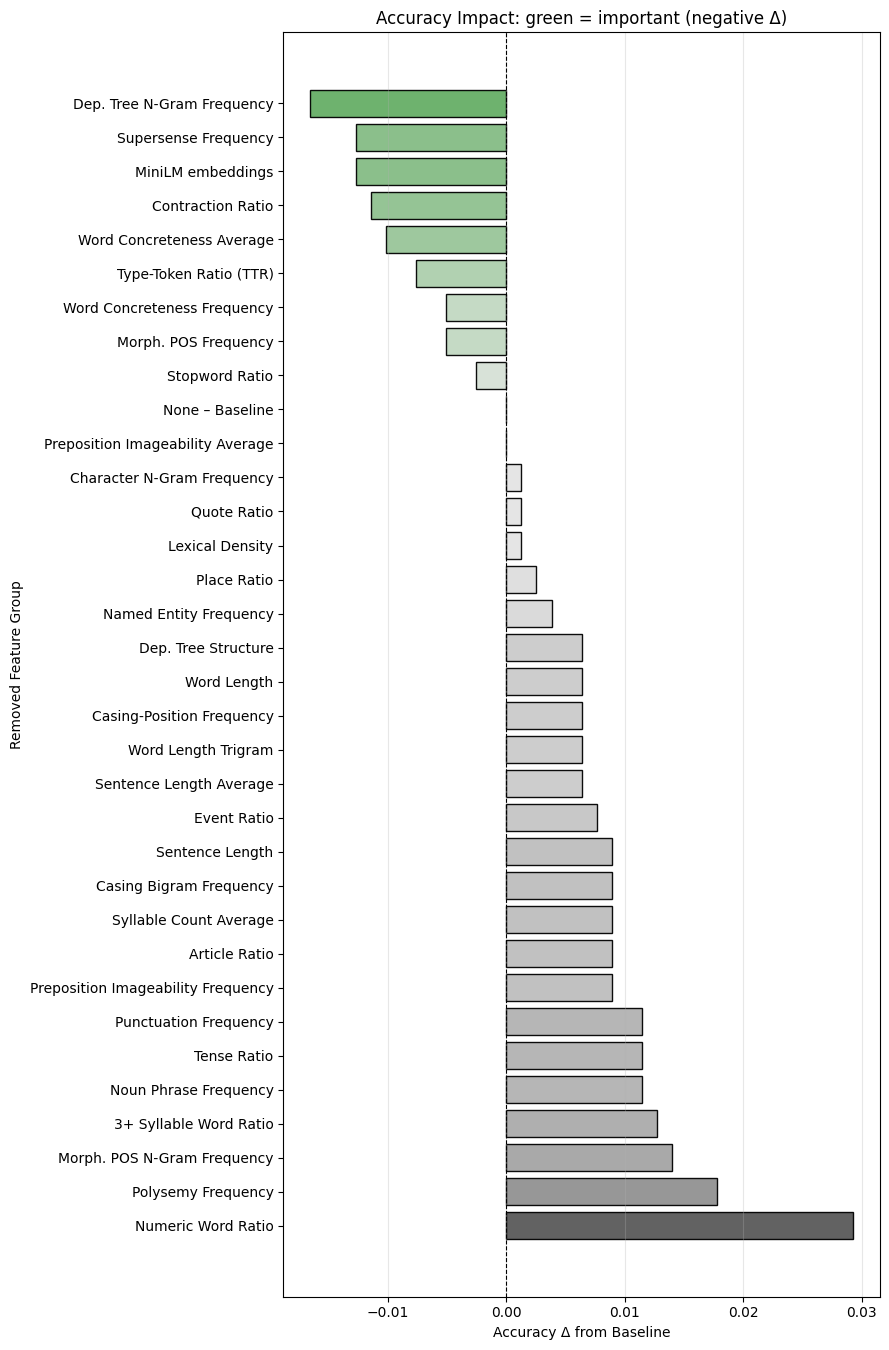

Saved accuracy delta plot -> data/figures/feature_importance_accuracy_delta.png


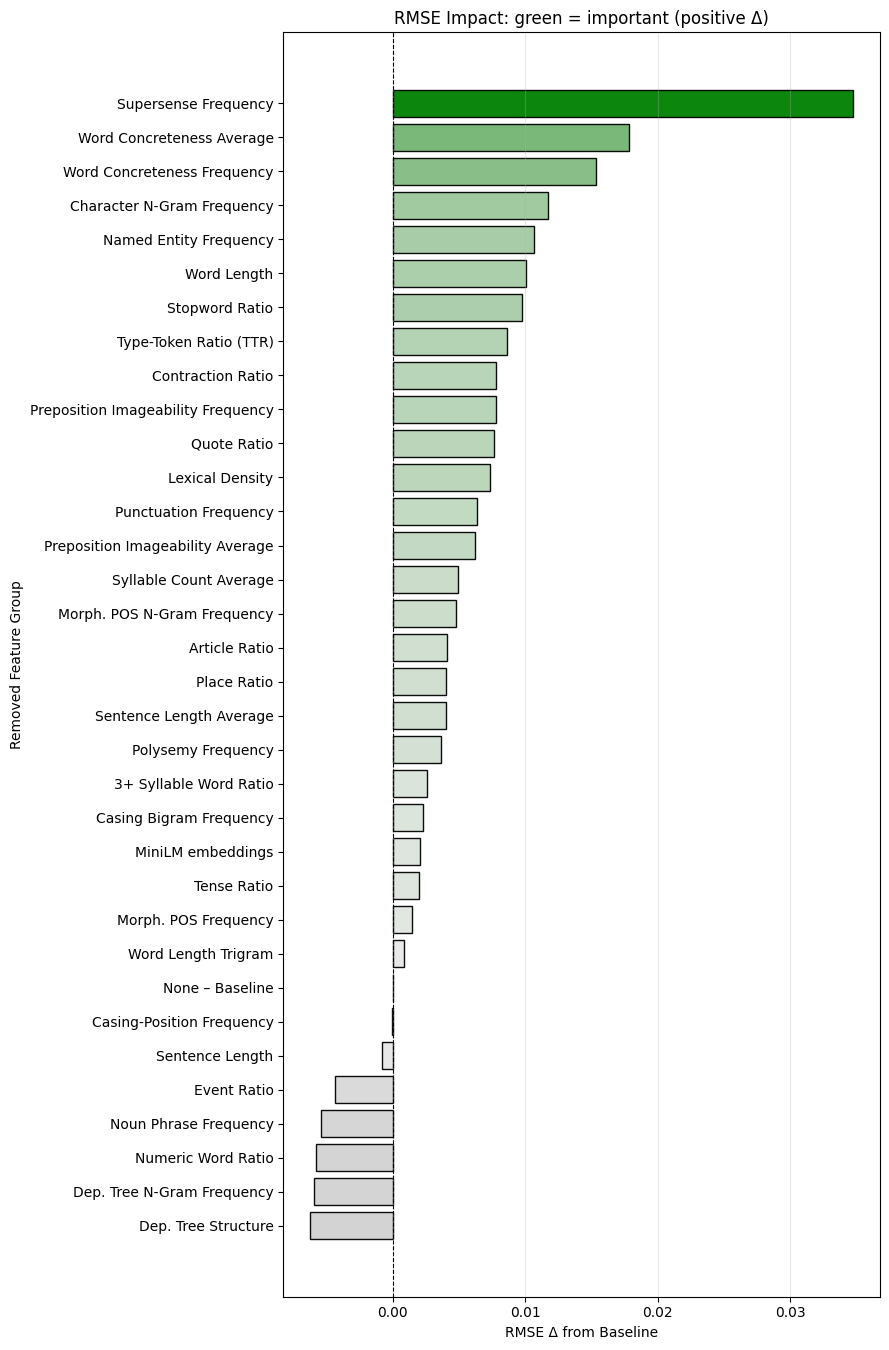

Saved RMSE delta plot -> data/figures/feature_importance_rmse_delta.png


KeyError: 'Macro F1 Δ'

In [35]:
import matplotlib.pyplot as plt

# Prepare DataFrame
plot_df = df.copy()
plot_df["Feature"] = plot_df["Removed Feature Group"]


def interp_color(a, b, t):
    return tuple(float(a[i] + (b[i] - a[i]) * t) for i in range(3))


def importance_colors(
    deltas,
    important_mask,
    base_gray=(0.92, 0.92, 0.92),
    green=(0.0, 0.5, 0.0),
    dark_gray=(0.35, 0.35, 0.35),
):
    abs_imp = np.abs(deltas.astype(float))
    max_imp = abs_imp.max()
    if max_imp <= 0:
        max_imp = 1.0
    colors = []
    for val, imp_flag, mag in zip(deltas, important_mask, abs_imp):
        t = mag / max_imp
        if imp_flag:
            colors.append(interp_color(base_gray, green, t))
        else:
            colors.append(interp_color(base_gray, dark_gray, t))
    return colors


error_kw = {"elinewidth": 1.0, "capsize": 3}

# 1) Accuracy: negative Δ = important
acc_sorted = plot_df.sort_values("Accuracy Δ", ascending=False)
acc_deltas = acc_sorted["Accuracy Δ"]
acc_mask = acc_deltas < 0
colors_acc = importance_colors(acc_deltas, acc_mask)
plt.figure(figsize=(9, max(6, 0.4 * len(acc_sorted))))
plt.barh(
    acc_sorted["Feature"],
    acc_sorted["Accuracy Δ"],
    color=colors_acc,
    alpha=0.95,
    edgecolor="black",
    error_kw=error_kw,
)
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel("Accuracy Δ from Baseline")
plt.ylabel("Removed Feature Group")
plt.title("Accuracy Impact: green = important (negative Δ)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    "/home/terra/Projects/vis-desc/modules/lab/data/figures/feature_importance_accuracy_delta.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("Saved accuracy delta plot -> data/figures/feature_importance_accuracy_delta.png")

# 2) RMSE: positive Δ = important
rmse_sorted = plot_df.sort_values("RMSE Δ", ascending=True)
rmse_deltas = rmse_sorted["RMSE Δ"]
rmse_mask = rmse_deltas > 0
colors_rmse = importance_colors(rmse_deltas, rmse_mask)
plt.figure(figsize=(9, max(6, 0.4 * len(rmse_sorted))))
plt.barh(
    rmse_sorted["Feature"],
    rmse_sorted["RMSE Δ"],
    color=colors_rmse,
    alpha=0.95,
    edgecolor="black",
    error_kw=error_kw,
)
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel("RMSE Δ from Baseline")
plt.ylabel("Removed Feature Group")
plt.title("RMSE Impact: green = important (positive Δ)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    "/home/terra/Projects/vis-desc/modules/lab/data/figures/feature_importance_rmse_delta.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("Saved RMSE delta plot -> data/figures/feature_importance_rmse_delta.png")

# 3) Macro F1: negative Δ = important
macro_sorted = plot_df.sort_values("Macro F1 Δ")
macro_deltas = macro_sorted["Macro F1 Δ"]
macro_mask = macro_deltas < 0
colors_macro = importance_colors(macro_deltas, macro_mask)
plt.figure(figsize=(9, max(6, 0.4 * len(macro_sorted))))
plt.barh(
    macro_sorted["Feature"],
    macro_sorted["Macro F1 Δ"],
    color=colors_macro,
    alpha=0.95,
    edgecolor="black",
    error_kw=error_kw,
)
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel("Macro F1 Δ from Baseline")
plt.ylabel("Removed Feature Group")
plt.title("Macro F1 Impact: green = important (negative Δ)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    "/home/terra/Projects/vis-desc/modules/lab/data/figures/feature_importance_macro_f1_delta.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("Saved Macro F1 delta plot -> data/figures/feature_importance_macro_f1_delta.png")

In [ ]:
# Export DataFrame as LaTeX with background gradient
from pathlib import Path
import matplotlib.pyplot as plt

latex_output_path = Path(
    "/home/terra/Projects/vis-desc/modules/lab/data/figures/feature_importance_table.tex"
)

# Get colormap for gradients
cmap_rdylgn = plt.get_cmap("RdYlGn")
cmap_rdylgn_r = plt.get_cmap("RdYlGn_r")


def get_color_for_value(value, col_name, vmin, vmax):
    """Map value to color based on gradient configuration."""
    if pd.isna(value) or vmin == vmax:
        return None
    norm_value = (value - vmin) / (vmax - vmin)
    if col_name == "RMSE Δ":
        rgba = cmap_rdylgn(norm_value)
    elif col_name == "Accuracy Δ":
        rgba = cmap_rdylgn_r(norm_value)
    else:
        return None
    return rgba[:3]  # RGB without alpha


# Build LaTeX table with colors
latex_lines = []
latex_lines.append(r"\begin{table}[hbtp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\small")
latex_lines.append(r"\begin{tabular}{l" + "r" * (len(df.columns) - 1) + "}")
latex_lines.append(r"\toprule")

# Header
header = " & ".join([col.replace("Δ", r"$\Delta$") for col in df.columns]) + r" \\"
latex_lines.append(header)
latex_lines.append(r"\midrule")

# Calculate vmin/vmax for gradient columns (centered at 0)
gradient_info = {}
for col in ["RMSE Δ", "Accuracy Δ"]:
    if col in df.columns:
        abs_max = max(abs(df[col].min()), abs(df[col].max()))
        gradient_info[col] = {"vmin": -abs_max, "vmax": abs_max}

# Data rows
for idx, row in df.iterrows():
    cells = []
    for col_idx, (col, val) in enumerate(row.items()):
        if col == "Removed Feature Group":
            cell_str = str(val).replace("–", r"--")
            if "Baseline" in str(val):
                cell_str = r"\textbf{" + cell_str + "}"
        elif isinstance(val, (int, float)) and not pd.isna(val):
            cell_str = f"{val:.4f}"
            # Apply color if this column has gradient
            if col in gradient_info:
                color_rgb = get_color_for_value(
                    val, col, gradient_info[col]["vmin"], gradient_info[col]["vmax"]
                )
                if color_rgb:
                    r, g, b = color_rgb
                    cell_str = (
                        r"\cellcolor[rgb]{"
                        + f"{r:.3f},{g:.3f},{b:.3f}"
                        + "}"
                        + cell_str
                    )
        else:
            cell_str = str(val)
        cells.append(cell_str)
    latex_lines.append(" & ".join(cells) + r" \\")

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\caption{Feature Importances}")
latex_lines.append(r"\label{tab:feature-importances}")
latex_lines.append(r"\end{table}")

tex = "\n".join(latex_lines)
latex_output_path.write_text(tex)
print(tex)
print(f"\nSaved LaTeX table -> {latex_output_path}")
print("\nNote: Add these packages to your LaTeX preamble:")
print(r"  \usepackage{booktabs}")
print(r"  \usepackage[table]{xcolor}")

\begin{table}[h]
\centering
\begin{tabular}{lrrr}
\toprule
Removed & RMSE & RMSE $\Delta$ & Accuracy $\Delta$ \\
\midrule
Supersense Frequency & 0.8948 & \cellcolor[rgb]{0.000,0.408,0.216}0.0347 & \cellcolor[rgb]{0.607,0.832,0.411}-0.0127 \\
Word Concreteness Average & 0.8778 & \cellcolor[rgb]{0.508,0.789,0.400}0.0178 & \cellcolor[rgb]{0.702,0.873,0.449}-0.0102 \\
Word Concreteness Frequency & 0.8753 & \cellcolor[rgb]{0.597,0.827,0.410}0.0153 & \cellcolor[rgb]{0.869,0.945,0.569}-0.0051 \\
Character N-Gram Frequency & 0.8717 & \cellcolor[rgb]{0.710,0.876,0.454}0.0117 & \cellcolor[rgb]{0.999,0.974,0.705}0.0013 \\
Named Entity Frequency & 0.8707 & \cellcolor[rgb]{0.741,0.890,0.474}0.0107 & \cellcolor[rgb]{0.997,0.921,0.617}0.0038 \\
Word Length & 0.8700 & \cellcolor[rgb]{0.757,0.897,0.484}0.0100 & \cellcolor[rgb]{0.996,0.863,0.532}0.0064 \\
Stopword Ratio & 0.8697 & \cellcolor[rgb]{0.765,0.900,0.489}0.0098 & \cellcolor[rgb]{0.933,0.972,0.657}-0.0025 \\
Type-Token Ratio (TTR) & 0.8686 & \c